<a href="https://colab.research.google.com/github/ARMargolis/melanoma-pytorch/blob/master/data_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

'\n!pip install -q kaggle\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json\n'

In [13]:
import tensorflow as tf, pandas as pd

def parse_TFR_data_labelled(sample):
    tfrec_format = {
          'image'                        : tf.io.FixedLenFeature([], tf.string),
          'image_name'                   : tf.io.FixedLenFeature([], tf.string),
          #'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
          #'sex'                          : tf.io.FixedLenFeature([], tf.int64),
          #'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
          #'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
          #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
          'target'                       : tf.io.FixedLenFeature([], tf.int64)
          }
    example = tf.io.parse_single_example(sample, tfrec_format)
        
    #img = p['image']
    #target = p['target']

    return example

def parse_TFR_data_unlabelled(sample):
    tfrec_format = {
          'image'                        : tf.io.FixedLenFeature([], tf.string),
          'image_name'                   : tf.io.FixedLenFeature([], tf.string),
          #'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
          #'sex'                          : tf.io.FixedLenFeature([], tf.int64),
          #'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
          #'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
          #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
          #'target'                       : tf.io.FixedLenFeature([], tf.int64)
          }
    example = tf.io.parse_single_example(sample, tfrec_format)
        
    #img = p['image']
    #target = p['target']

    return example

def decode_image(img , IMG_DIMS):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img , [IMG_DIMS , IMG_DIMS])
    return img

In [4]:
#!git clone https://github.com/ARMargolis/melanoma-pytorch.git

In [28]:
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import torch
from torch import nn, sigmoid
from torch.nn import functional as F
from torch.utils import data
from torch.optim import Adam

from PIL import Image, ImageOps
from torchvision import transforms, utils


default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MelanomaDatasetCL(data.Dataset):
    # TODO initialize conv layers and fc layers in a particular way. Important for our experiment
    # TODO add cuda support
    
    def __init__(self, gcs_path, train, device = default_device, resolution=1000, subsample=None, **specifications):
        """
        Initializes the dataset. Will use .tfrec files
        gcs_path (str): GCS path where images and labels are stored
        specifications (optional): any extra keyword args are stored in a dict. Can include:
            -transform
            -resolution: what size do we want to resize the images to? Square or rectangular?
        """
        
        self.train=train
        #  Handle specifications
        if specifications:
            print('Specifications:')
            for key, value in specifications.items():
                print(key, ' : ', value)
            print('----------------------')
        #images generally are 1053x1872 coming in - will centercrop to 1000 x 1000
        self.initial_resolution = (1053,1872)
        if 'initial_resolution' in specifications:
            if isinstance(specifications['initial_resolution']):
                self.initial_resolution = specifications['initial_resolution']
            else:
                print('Invalid format for inital resolution. Give a tuple')
        # Set resolution of actual samples to feed into the model
        self.resolution = resolution # 1000 default

        # Figure out what transforms to use
        if 'transform' not in specifications:
            # If I didn't specify a transform
            if self.train:
                # if a training dataset
                self.transform = transforms.Compose(
                    [
                        #transforms.Resize(self.initial_resolution),
                        #transforms.CenterCrop(self.initial_resolution[0]), #get a square image
                        #transforms.RandomResizedCrop(size=self.resolution, scale=(0.8, 1.0)),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.CenterCrop(self.resolution),
                        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                        transforms.ToTensor(),
                        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) #Taken from overall dataset
                    ]
                )
            else:
                # if test
                self.transform = transforms.Compose(
                    [
                        transforms.Resize(self.initial_resolution),
                        transforms.CenterCrop(self.initial_resolution[0]), #get a square image
                        transforms.CenterCrop(self.resolution), 
                        transforms.ToTensor(),
                        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        
                    ]
                )
        else:
            if specifications['transform'] == None:
                # If I specifically specify no transform, then the only transform is to_tensor
                self.transform = transforms.functional.to_tensor #self.transform is a function
            else:
                # If I directly feed in a transform, use that
                self.transform = specifications['transform']

        self.gcs_path = gcs_path
        tfrec_dataset = tf.data.TFRecordDataset(gcs_path)
        tfrec_dataset_cache=tfrec_dataset.cache()
        if self.train:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(parse_TFR_data_labelled)
        else:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(parse_TFR_data_unlabelled)
        self.data_iter=tfrec_dataset_cache_map1.as_numpy_iterator()
        self.label_df=pd.Series(tf.io.gfile.glob(gcs_path))

        self.device = device
        self.subsample=subsample
    
    def __len__(self):
        return self.label_df.shape[0]

    def __getitem__(self, idx):
        """
            Get a single sample
            Want this method to be very fast, i.e. few or no if statements, etc.
        """
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        next_data=next(self.data_iter)
        if self.train:
          label=next_data['target']
          #If you want to subsample due to a class imbalance
          if self.subsample:
            while np.random.random()>self.subsample[label]:
              next_data=next(self.data_iter)
              label=next_data['target']
        name=next_data['image_name']
        
        # get PIL image
        decoded_img=decode_image(next_data['image'],1024).numpy().astype(np.uint8)
        image = Image.fromarray(decoded_img)
        image = self.transform(image)
        image = image.to(self.device)

        if self.train: #Include the label if it's training data
          return (image, name, torch.LongTensor([label]))
        return (image, name)

    def display_sample(self, idx):
        pic, name, label = self.__getitem__(idx)
        pic = pic.to('cpu')
        pic = transforms.functional.to_pil_image(pic)
        print('name:',name,'label:', label.cpu().numpy())
        # if not using in jupyter notebook context, show the image directly instead of returning it
        # pic.show()
        return pic

In [6]:
default_config = {
    'input_shape':(1,3,244,244),
    'n_classes':1, #binary classification
    'base_channels':3,
    'block_type':'basic',
    'depth':20, # depth should be two more than a multiple of six
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'

}

# Credit for all code below goes to https://github.com/hysts/pytorch_resnet/blob/master/resnet.py
# The license of said project allows for reuse (commercial or otherwise), modification, and distribution of the code, without limitations

class MelanomaNet(nn.Module):
    def __init__(self, config=default_config):
        super(MelanomaNet, self).__init__()
        print(config)

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        block_type = config['block_type']
        depth = config['depth']
        self.device = config['device']

        assert block_type in ['basic', 'bottleneck']
        if block_type == 'basic':
            print('block type: ', block_type)
            block = BasicBlock
            n_blocks_per_stage = (depth - 2) // 6
            print('blocks per stage: ', n_blocks_per_stage)
            assert n_blocks_per_stage * 6 + 2 == depth
        else:
            block = BottleneckBlock
            n_blocks_per_stage = (depth - 2) // 9
            assert n_blocks_per_stage * 9 + 2 == depth

        n_channels = [
            base_channels, base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage, block, stride=1)
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, block, stride=2)
        self.stage3 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, block, stride=2)

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]

        self.fc = nn.Linear(self.feature_size, n_classes)

        # initialize weights
        #self.apply(initialize_weights)

        self.to(self.device)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name, block(
                        in_channels, out_channels, stride=stride))
            else:
                stage.add_module(block_name,
                                 block(out_channels, out_channels, stride=1))
        return stage

    def _forward_conv(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def predict(self, x, threshold=0.5):
        # predict 0 (benign) or 1 (malignant)
        model.eval()
        with torch.no_grad():
            a = self.forward(x)
            a = sigmoid(a)
            # Round to 0 or 1 by threshold. 
            # In a clinical setting, a false negative would probably be worse than 
            # a false positive so we would set the confidence threshold lower
            a = (a.detach().cpu().numpy() > threshold).astype(int)
            return a


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y

In [7]:
GCS_PATH=r'gs://kds-ca51e6aef2639960584a063f30a434cebf2d6f442486293bcf54f8ca/'
train_recs=tf.io.gfile.glob(GCS_PATH+'tfrecords/train*')
print(default_device)
mds = MelanomaDatasetCL(gcs_path=train_recs, train = True, resolution=500, subsample=[0.04,1])
mdl = DataLoader(mds, batch_size = 8, shuffle=False)
model = MelanomaNet()

cuda
{'input_shape': (1, 3, 244, 244), 'n_classes': 1, 'base_channels': 3, 'block_type': 'basic', 'depth': 20, 'device': 'cuda'}
block type:  basic
blocks per stage:  3


In [11]:
from time import ctime

# Try overfitting a batch to make sure the model + optimizer is operating properly
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
EPOCHS = 5
TRAIN_STEPS=100
VAL_STEPS=20
loss_bce = nn.BCELoss()
pred_list=[]
y_list=[]
loss_list = []
val_loss_list=[]
print('Begin', ctime())
for i in range(EPOCHS):
  batch_num=0
  for s in range(TRAIN_STEPS):
    for batch in mdl:
      batch_num+=1
      assert model.training
      #zero the optimizer
      optimizer.zero_grad()

      x, name, y = batch
      x=x.to(default_device)
      y=y.to(default_device)
      #with torch.no_grad():
      #    model.eval()
      #    print(model.predict(x))
      #    model.train()
      pred=sigmoid(model(x))
      loss = loss_bce(pred,y.float())
      loss.backward()
      scheduler.step()

      y_list.append(y.to('cpu').numpy())
      pred_list.append(pred.detach().to('cpu').numpy())
      loss_list.append(loss.item())
    if s%20==19:
      print('Epoch', i,'step', s, 'complete.',batch_num, 'batches. Avg Loss (last 20):', sum(loss_list[-20:])/20, ctime())

  for s in range(VAL_STEPS):
    for batch in mdl:
      batch_num+=1

      x, name, y = batch
      x=x.to(default_device)
      y=y.to(default_device)
      #with torch.no_grad():
      #    model.eval()
      #    print(model.predict(x))
      #    model.train()
      pred=sigmoid(model(x))
      loss = loss_bce(pred,y.float())
      val_loss_list.append(loss.item())
    val_batches=batch_num-2*TRAIN_STEPS
    val_loss_mean=sum(val_loss_list[-val_batches:])/val_batches
  print('Epoch', i, val_batches, 'validation batches. Validation Losses:', val_loss_mean, ctime())
  print(pred.detach().to('cpu').numpy())
  print(y.detach().to('cpu').numpy())
      
  mds = MelanomaDatasetCL(gcs_path=train_recs, train = True, resolution=500, subsample=[0.04,1])
  mdl = DataLoader(mds, batch_size = 8, shuffle=False)

torch.save(model.state_dict(), '/content/gdrive/My Drive/melanoma0816sgd_e35.pth')

Begin Sun Aug 16 16:21:44 2020
Epoch 0 step 19 complete. 40 batches. Avg Loss (last 20): 0.5217656925320625 Sun Aug 16 16:23:17 2020
Epoch 0 step 39 complete. 80 batches. Avg Loss (last 20): 0.5364250242710114 Sun Aug 16 16:24:50 2020
Epoch 0 step 59 complete. 120 batches. Avg Loss (last 20): 0.5575731247663498 Sun Aug 16 16:26:22 2020
Epoch 0 step 79 complete. 160 batches. Avg Loss (last 20): 0.5388621881604194 Sun Aug 16 16:27:54 2020
Epoch 0 step 99 complete. 200 batches. Avg Loss (last 20): 0.49290467947721484 Sun Aug 16 16:29:30 2020
Epoch 0 31 validation batches. Validation Losses: 0.5582938453843517 Sun Aug 16 16:30:41 2020
[[0.4418814 ]
 [0.22956957]
 [0.7342061 ]
 [0.01946332]
 [0.05666235]
 [0.07634986]
 [0.37676132]
 [0.50684124]]
[[0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
Epoch 1 step 19 complete. 40 batches. Avg Loss (last 20): 0.4704327419400215 Sun Aug 16 16:32:18 2020
Epoch 1 step 39 complete. 80 batches. Avg Loss (last 20): 0.5096929579973221 Sun Aug 16 16:33:52 2020
Epo

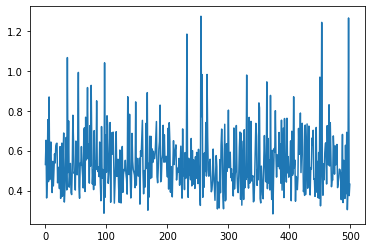

In [15]:
pd.Series(loss_list[-500:]).plot()

In [16]:
[y.sum() for y in y_list[-10:]] #Number of malignant cases in last 10 batches

[3, 2, 3, 1, 4, 1, 2, 6, 2, 1]

In [17]:
pred_list[-8]

array([[0.24678096],
       [0.2524192 ],
       [0.18804903],
       [0.34110937],
       [0.3269683 ],
       [0.00641086],
       [0.43880987],
       [0.5568447 ]], dtype=float32)

In [18]:
y_list[-8]

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [55]:
test_recs=tf.io.gfile.glob(GCS_PATH+'tfrecords/test*')
mds_test = MelanomaDatasetCL(gcs_path=test_recs, train = False, resolution=500)
mdl_test = DataLoader(mds_test, batch_size = 8, shuffle=False)

In [56]:
batch_num=0
pred_dict={}
print('Begin', ctime())
for s in range(700): #There are 10982 test cases
  for batch in mdl_test:
    batch_num+=1
    x, names = batch
    x=x.to(default_device)
    pred=sigmoid(model(x)).detach().to('cpu').numpy()
    pred_dict.update({names[k].decode('utf8'):pred[k][0] for k in range(len(names))} )

  if s%50==49:
    print('Step', s, batch_num, 'test batches', ctime())
print('Done', batch_num, 'test batches', ctime())

Begin Sun Aug 16 18:55:23 2020
Step 0 2 test batches Sun Aug 16 18:55:25 2020
Step 50 102 test batches Sun Aug 16 18:56:23 2020
Step 100 202 test batches Sun Aug 16 18:57:22 2020
Step 150 302 test batches Sun Aug 16 18:58:20 2020
Step 200 402 test batches Sun Aug 16 18:59:19 2020
Step 250 502 test batches Sun Aug 16 19:00:17 2020
Step 300 602 test batches Sun Aug 16 19:01:17 2020
Step 350 702 test batches Sun Aug 16 19:02:14 2020
Step 400 802 test batches Sun Aug 16 19:03:13 2020
Step 450 902 test batches Sun Aug 16 19:04:11 2020
Step 500 1002 test batches Sun Aug 16 19:05:08 2020
Step 550 1102 test batches Sun Aug 16 19:06:04 2020
Step 600 1202 test batches Sun Aug 16 19:07:01 2020
Step 650 1302 test batches Sun Aug 16 19:07:58 2020
Done 1372 test batches Sun Aug 16 19:08:40 2020


In [59]:
#The next cells solve the problem that there are 8 images missing
from google.colab import files
files.upload()
#download test.csv from Kaggle and upload it here

Saving test.csv to test.csv


{'test.csv': b'image_name,patient_id,sex,age_approx,anatom_site_general_challenge\nISIC_0052060,IP_3579794,male,70.0,\nISIC_0052349,IP_7782715,male,40.0,lower extremity\nISIC_0058510,IP_7960270,female,55.0,torso\nISIC_0073313,IP_6375035,female,50.0,torso\nISIC_0073502,IP_0589375,female,45.0,lower extremity\nISIC_0074618,IP_4438996,male,50.0,lower extremity\nISIC_0076801,IP_3110660,male,45.0,upper extremity\nISIC_0077586,IP_8578442,male,50.0,lower extremity\nISIC_0082004,IP_0817448,female,45.0,torso\nISIC_0082785,IP_3634181,male,65.0,lower extremity\nISIC_0085332,IP_7899071,male,40.0,torso\nISIC_0087243,IP_7746230,male,60.0,torso\nISIC_0088167,IP_0581821,female,30.0,upper extremity\nISIC_0089356,IP_8564532,female,65.0,torso\nISIC_0090283,IP_9657527,male,55.0,head/neck\nISIC_0092481,IP_4288676,female,55.0,lower extremity\nISIC_0095455,IP_2849250,female,40.0,lower extremity\nISIC_0095790,IP_9918026,male,65.0,torso\nISIC_0097719,IP_3331830,male,45.0,torso\nISIC_0099348,IP_4403761,female,45

In [62]:
test_df=pd.read_csv('test.csv')
print('Begin', ctime())
for img_name in test_df['image_name']:
  if img_name not in pred_dict:
    print(img_name)
    pred_dict[img_name]=0.02
print('End', ctime())

Begin Sun Aug 16 19:17:07 2020
ISIC_0258717
ISIC_1378676
ISIC_1530517
ISIC_4428229
ISIC_7527610
ISIC_8106490
End Sun Aug 16 19:17:07 2020


In [63]:
pd.Series(pred_dict,
          name='target').to_csv('/content/gdrive/My Drive/melanoma0816sgd_e{}_preds.csv'.format(i+1),
                            index_label='image_name')